# Algorithmes d’apprentissage et modèles statistiques
## Un exemple de régression logistique régularisée et de validation croisée pour prédire le décrochage scolaire
## Code des analyses présentées dans la partie 2 du chapitre 23: régression logistique régularisée
### Dans M. Corbière & N. Larivière (Eds.), Méthodes qualitatives, quantitatives et mixtes dans la recherche en sciences humaines, sociales et de la santé, 2e édition. Québec, QC : PUQ. (sous presse)
Contact: eric.lacourse@umontreal.ca
### Auteurs: Éric Lacourse, Charles-Édouard Giguère et Véronique Dupéré
#### Analyste: Charles-Édouard Giguère
#### Transcription du code: Clémentine Courdi

In [2]:
#Téléchargement des packages nécessaire à l'analyse

install.packages("CUFF") #Package CUFF (Charles's Utility Function using Formula) pour affichage des variables
install.packages ("dplyr") #Package dplyr pour manipulation flexible des données
install.packages("ggplot2")#Package ggplot2 pour création de graphiques 
install.packages("haven") #Package haven pour importer des données d'autres formats dans R
install.packages("knitr") #Package knitr pour production de tableau
install.packages("xtable") #Package xtable pour production de tableau
install.packages("pairwise") #Package xtable pour production de tableau


require(dplyr, quietly = TRUE, warn.conflicts = FALSE) 
require(ggplot2, quietly = TRUE, warn.conflicts = FALSE) 
require(CUFF, quietly = TRUE, warn.conflicts = FALSE) 
require(haven, quietly = TRUE, warn.conflicts = FALSE)
require(knitr, quietly = TRUE, warn.conflicts = FALSE)
require(xtable, quietly = TRUE, warn.conflicts = FALSE)
require(pairwise, quietly = TRUE, warn.conflicts = FALSE) 

opts_chunk$set(echo = TRUE, prompt = TRUE, comment = "", cache = TRUE)
options(xtable.comment = FALSE)


The downloaded binary packages are in
	/var/folders/j_/xsy2mlfn1njgfsk39zt2tpyh0000gn/T//Rtmp419TjM/downloaded_packages

The downloaded binary packages are in
	/var/folders/j_/xsy2mlfn1njgfsk39zt2tpyh0000gn/T//Rtmp419TjM/downloaded_packages

The downloaded binary packages are in
	/var/folders/j_/xsy2mlfn1njgfsk39zt2tpyh0000gn/T//Rtmp419TjM/downloaded_packages

The downloaded binary packages are in
	/var/folders/j_/xsy2mlfn1njgfsk39zt2tpyh0000gn/T//Rtmp419TjM/downloaded_packages

  There is a binary version available but the source version is later:
      binary source needs_compilation
knitr   1.28   1.29             FALSE



installing the source package ‘knitr’





The downloaded binary packages are in
	/var/folders/j_/xsy2mlfn1njgfsk39zt2tpyh0000gn/T//Rtmp419TjM/downloaded_packages

The downloaded binary packages are in
	/var/folders/j_/xsy2mlfn1njgfsk39zt2tpyh0000gn/T//Rtmp419TjM/downloaded_packages


In [3]:
#Télécharger le package glmnet et latex2exp pour la réalisation des analyses avec régularisation
install.packages("glmnet")
install.packages("latex2exp")
require(glmnet)
require(latex2exp)


The downloaded binary packages are in
	/var/folders/j_/xsy2mlfn1njgfsk39zt2tpyh0000gn/T//Rtmp419TjM/downloaded_packages

The downloaded binary packages are in
	/var/folders/j_/xsy2mlfn1njgfsk39zt2tpyh0000gn/T//Rtmp419TjM/downloaded_packages


Loading required package: glmnet

Loading required package: Matrix

Loaded glmnet 4.0-2

Loading required package: latex2exp



In [4]:
#Télécharger le fichier de données à partir de github
SD.csv <- "https://github.com/ericlacourse/Code-chapitre-23.git"

In [5]:
#Lire le fichier de données téléchargé depuis github (vérification du téléchargement des données et des packages)
library(readr)
SD.df <- read.csv("Code-chapitre-23/SD.csv")
ls(SD.df)

[1] "ADAPT"         "AGE"           "AIMES"         "AMB"          
 [5] "CHRONSEVACT"   "DOUBLE"        "ECOLE"         "EVDISTMOD"    
 [9] "EVDISTSEV"     "ID"            "IMP"           "LOW203DICO"   
[13] "LOW236DICO"    "LOW269DICO"    "LOW2912DICO"   "MALE"         
[17] "MINORITY"      "MODER203DICO"  "MODER236DICO"  "MODER269DICO" 
[21] "MODER2912DICO" "NOTES_FR"      "NOTES_MATH"    "PAR_IMM"      
[25] "PAR_SEP"       "PR_AUTRES"     "SCOLMAX"       "SEVER03DICO"  
[29] "SEVER36DICO"   "SEVER69DICO"   "SEVER912DICO"  "SRDQ"         
[33] "STATUT"        "TRAVAILM"      "TRAVAILP"      "X"

In [30]:
#Diviser l'ensemble de données pour créer un sous-ensemble de données d'entrainement et un sous-ensemble de données de test (avec germe aléatoire pour assurer la reproductibilité des résultats)
set.seed(1234)
ECH.TRAIN <- sample(1:1000, 700)
TRAIN.df <- SD.df[ECH.TRAIN,]
TEST.df <- SD.df[-ECH.TRAIN,]

In [31]:
TRAIN.df <- as.data.frame(TRAIN.df)
TEST.df <- as.data.frame(TEST.df)

In [32]:
#Standardisation des variables
TRAIN.df[,-(2:4)]  <- scale(TRAIN.df[,-(2:4)])
TEST.df[,-(2:4)]  <- scale(TEST.df[,-(2:4)])

In [29]:
#Lire l'ensemble de données d'entrainement pour vérifier la réussite de l'étape précédente
ls (TRAIN.df)

[1] "ADAPT"         "AGE"           "AIMES"         "AMB"          
 [5] "CHRONSEVACT"   "DOUBLE"        "ECOLE"         "EVDISTMOD"    
 [9] "EVDISTSEV"     "ID"            "IMP"           "LOW203DICO"   
[13] "LOW236DICO"    "LOW269DICO"    "LOW2912DICO"   "MALE"         
[17] "MINORITY"      "MODER203DICO"  "MODER236DICO"  "MODER269DICO" 
[21] "MODER2912DICO" "NOTES_FR"      "NOTES_MATH"    "PAR_IMM"      
[25] "PAR_SEP"       "PR_AUTRES"     "SCOLMAX"       "SEVER03DICO"  
[29] "SEVER36DICO"   "SEVER69DICO"   "SEVER912DICO"  "SRDQ"         
[33] "STATUT"        "TRAVAILM"      "TRAVAILP"      "X"

In [10]:
#Lire l'ensemble de données de test pour vérifier la réussite de l'étape précédente
ls (TEST.df)

[1] "ADAPT"         "AGE"           "AIMES"         "AMB"          
 [5] "CHRONSEVACT"   "DOUBLE"        "ECOLE"         "EVDISTMOD"    
 [9] "EVDISTSEV"     "ID"            "IMP"           "LOW203DICO"   
[13] "LOW236DICO"    "LOW269DICO"    "LOW2912DICO"   "MALE"         
[17] "MINORITY"      "MODER203DICO"  "MODER236DICO"  "MODER269DICO" 
[21] "MODER2912DICO" "NOTES_FR"      "NOTES_MATH"    "PAR_IMM"      
[25] "PAR_SEP"       "PR_AUTRES"     "SCOLMAX"       "SEVER03DICO"  
[29] "SEVER36DICO"   "SEVER69DICO"   "SEVER912DICO"  "SRDQ"         
[33] "STATUT"        "TRAVAILM"      "TRAVAILP"      "X"

In [33]:
#Les partitions et la fonction crossval sont construites afin de préparer la validation croisée.
#Division des données d'entrainement en 10 groupes de 70 individus (observations)
PARTITION = sample(rep(1:10, rep(70,10)),700)

#Création de la fonction crossval pour la validation croisée à 10-plis 
crossval <- function(mod){
    f1 <- function(x){
        modi = update(mod, data = TRAIN.df[!(PARTITION %in% x),])
        table(1*(predict(modi, newdata = TRAIN.df[PARTITION %in% x,],
                         type = "resp")>0.5),
              TRAIN.df[(PARTITION %in% x),"STATUT"])
    }
 CVT <- mapply(f1, x = 1:10)
    as.table(matrix(apply(CVT, 1, sum), 2, 2,
                    dimnames = list(c("P.ND","P.D"),
                                    c("T.ND","T.D"))))
} 

In [34]:
#Un modèle additif (sans régularisation) de régression logistique est ajusté sur l’échantillon d’entraînement.
#Régression logistique classique; données d’entraînement
var.model <- c("MALE", "AGE", "PAR_IMM", "MINORITY", "SCOLMAX", "TRAVAILM", "TRAVAILP", "PAR_SEP", "ADAPT",
                "SRDQ", "EVDISTSEV", "EVDISTMOD","SEVER03DICO",
                "SEVER36DICO", "SEVER69DICO", "SEVER912DICO",
                "MODER203DICO", "MODER236DICO", "MODER269DICO",
                "MODER2912DICO", "LOW203DICO", "LOW236DICO",
                "LOW269DICO", "LOW2912DICO", "CHRONSEVACT")
glm1 <- glmnet(x = TRAIN.df[, var.model] %>% as.matrix, y = TRAIN.df[,"STATUT"], lambda=0, family = "binomial")

#Visualisation des résultats 
print(glm1)
predict(glm1, type="coef", "lambda.min", allCoef = TRUE)


Call:  glmnet(x = TRAIN.df[, var.model] %>% as.matrix, y = TRAIN.df[,      "STATUT"], family = "binomial", lambda = 0) 

  Df  %Dev Lambda
1 25 16.07      0


26 x 1 sparse Matrix of class "dgCMatrix"
                       s0
(Intercept)    0.01223880
MALE           0.11619607
AGE            0.37832290
PAR_IMM       -0.02354991
MINORITY       0.01117619
SCOLMAX        0.28359589
TRAVAILM       0.11628193
TRAVAILP      -0.10514515
PAR_SEP        0.54567272
ADAPT         -0.12379524
SRDQ          -0.04120007
EVDISTSEV      0.26398912
EVDISTMOD     -0.49879199
SEVER03DICO    0.43484789
SEVER36DICO   -0.06016151
SEVER69DICO   -0.45572581
SEVER912DICO  -0.01289725
MODER203DICO  -0.36817345
MODER236DICO   0.36277321
MODER269DICO   0.44343925
MODER2912DICO  0.09907921
LOW203DICO     0.25546687
LOW236DICO     0.12153723
LOW269DICO    -0.23443896
LOW2912DICO   -0.17378213
CHRONSEVACT    0.60983017

In [35]:
#Prédiction à l'aide de la régression logistique classique
glm1p <- predict(glm1, newx = TRAIN.df[,var.model] %>%
                  as.matrix, s = "lambda.min")

In [41]:
#Table de classification montrant la performance prédictive du modèle (fréquences, puis pourcentages)
cv0 <- table(1*(glm1p>0), TRAIN.df$STATUT)
cv0
prop.table(cv0)*100
sprintf("%.1f%% de bonne classification", sum(diag(prop.table(cv0)))*100)

   
      0   1
  0 245 105
  1 104 246

   
           0        1
  0 35.00000 15.00000
  1 14.85714 35.14286

[1] "70.1% de bonne classification"

Passons maintenant aux modèles avec régularisation.

La régularisation ou estimateurs par rétrécissement consiste à pénaliser la fonction objective (moindre carré) servant à estimer les coefficients. Essentiellement, il s’agit d’estimer les coefficients en donnant une pénalité de façon à réduire la dimension de la régression. Une régression OLS aura p paramètres à estimer. Une régression avec régularisation aura un nombre de degrés de liberté inférieur à p permettant d’avoir un modèle linéairement plus parcimonieux. Pour estimer les coefficients d’un modèle régularisé, on utilise la fonction objective suivante:

$$
RSS_{shrinkage} = (Y - BX) + \lambda f(B)
$$

Nous utilisons trois méthodes correspondant à trois pénalités :

1.La méthode de régularisation de Ridge utilise une pénalité quadratique.
$$
RSS_{shrinkage} =(Y - BX)+ \lambda \sum_{i=1}^p \ \beta_i^2
$$

2.La méthode du Lasso utilise une pénalité en valeur absolue.
Cette pénalité fait en sorte que si un coefficient est à 0 pour un $\lambda$ donné il restera fixé à 0 pour tous les $\lambda$* > $\lambda$.
$$
RSS_{shrinkage} = (Y - BX)+\lambda \sum_{i=1}^p \ |\beta_i|
$$

3.La méthode de régularisation elastic net utilise un mélange de deux pénalités.
Cette méthode introduit un nouveau paramètre ($\alpha$) à estimer dans le modèle. En utilisant la paramétrisation suivante, on obtient que $\alpha$ = 0 correspond à une régression de Ridge et $\alpha$ = 1 correspond à une régression de lasso. Un alpha entre 0 et 1 produit un mélange des deux pénalités.
$$
RSS_{shrinkage} = (Y - BX)+ + (1 - \alpha) ( \sum_{i=1}^p \ \beta_i^2 )  + (\alpha) ( \lambda \sum_{i=1}^p \ |\beta_i|  )
$$

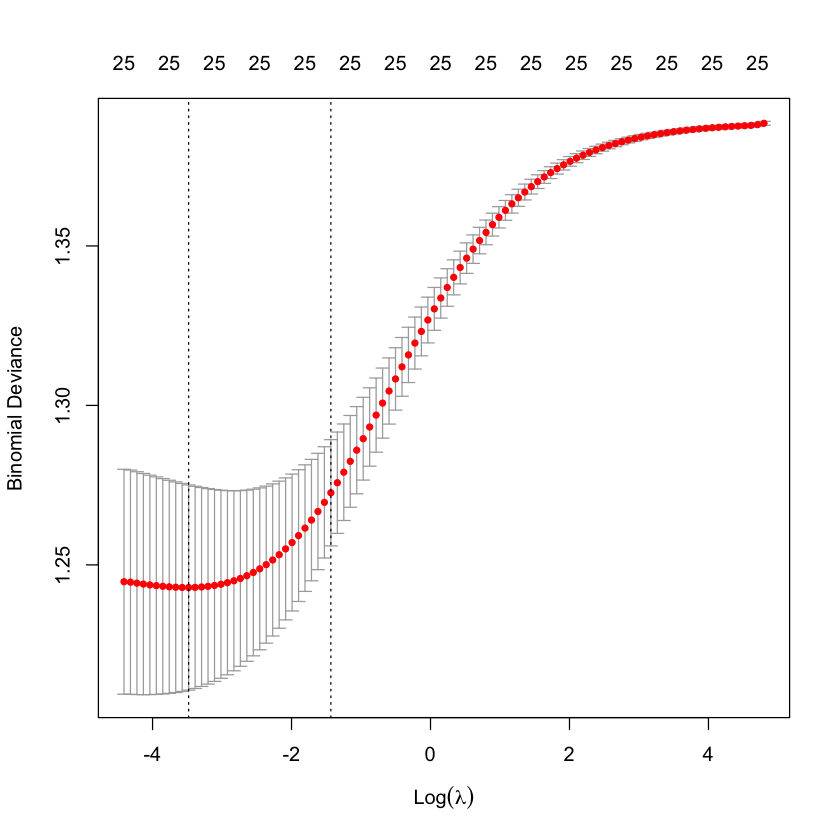

In [82]:
##Régression logistique avec régularisation ridge
#Sélection du lambda par validation croisée à 10 plis
var.model <- c("MALE", "AGE", "PAR_IMM", "MINORITY", "SCOLMAX", "TRAVAILM", "TRAVAILP", "PAR_SEP", "ADAPT",
                "SRDQ", "EVDISTSEV", "EVDISTMOD","SEVER03DICO",
                "SEVER36DICO", "SEVER69DICO", "SEVER912DICO",
                "MODER203DICO", "MODER236DICO", "MODER269DICO",
                "MODER2912DICO", "LOW203DICO", "LOW236DICO",
                "LOW269DICO", "LOW2912DICO", "CHRONSEVACT")

cv.glmn1 <- cv.glmnet(x= TRAIN.df[,var.model] %>% as.matrix,
                      y = TRAIN.df[,"STATUT"], alpha = 0, nfolds = 10, 
                      foldid = PARTITION, intercept= TRUE, 
                      family = "binomial", standardize = TRUE)

#Visualisation des résultats de la validation croisée avec régularisation ridge (valeur de lambda optimale indiquée par les lignes verticales pointillées)
plot(cv.glmn1)

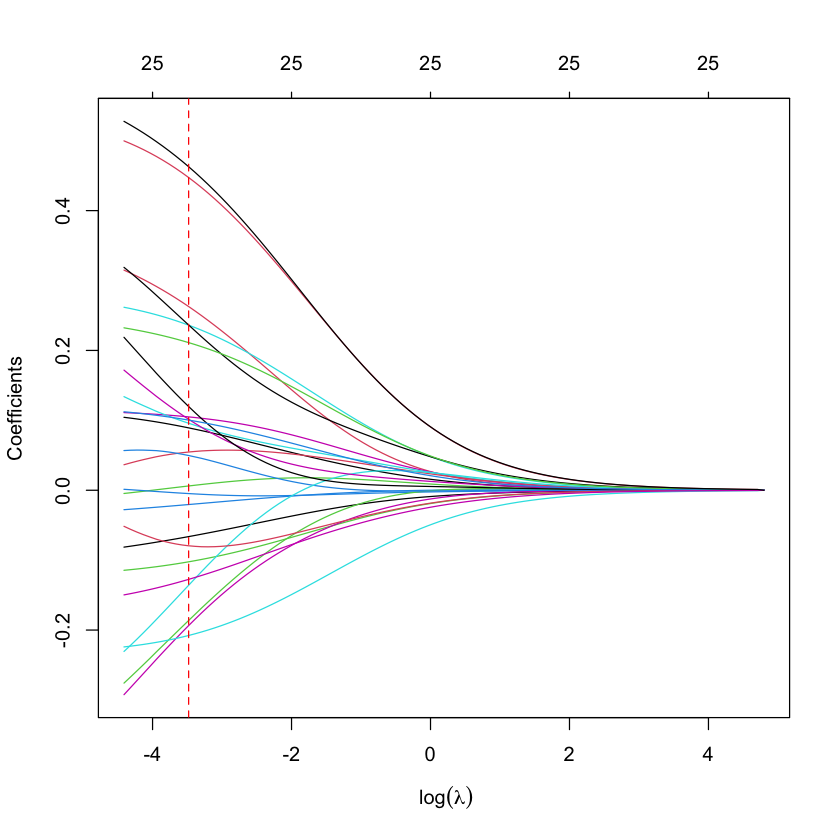

In [83]:
##Régression logistique avec régularisation ridge 
glmn1.0 <- glmnet(x = TRAIN.df[, var.model] %>% as.matrix,
                  y = TRAIN.df[,"STATUT"], alpha = 0, family = "binomial")

#Visualisation: évolution des coefficients selon valeur de lambda avec régularisation ridge + ligne rouge indiquant le lambda optimal
plot(glmn1.0, xvar = "lambda", label = FALSE, xlab = ~ log(lambda))
abline( v = log(cv.glmn1$lambda.min), col = "red", lty = 2)

In [84]:
#Prédiction à l'aide de la régression logistique avec régularisation ridge
glmn1p <- predict(cv.glmn1, newx = TRAIN.df[,var.model] %>%
                    as.matrix, s = "lambda.min") 

In [85]:
#Table de classification montrant la performance prédictive du modèle
cv2 <- table(1*(glmn1p>0), TRAIN.df$STATUT)
cv2
prop.table(cv2)*100
sprintf("%.1f%% de bonne classification", sum(diag(prop.table(cv2)))*100)

   
    -1.0021446507074 0.996434424777448
  0              243               100
  1              106               251

   
    -1.0021446507074 0.996434424777448
  0        0.3471429         0.1428571
  1        0.1514286         0.3585714

[1] "70.6% de bonne classification"

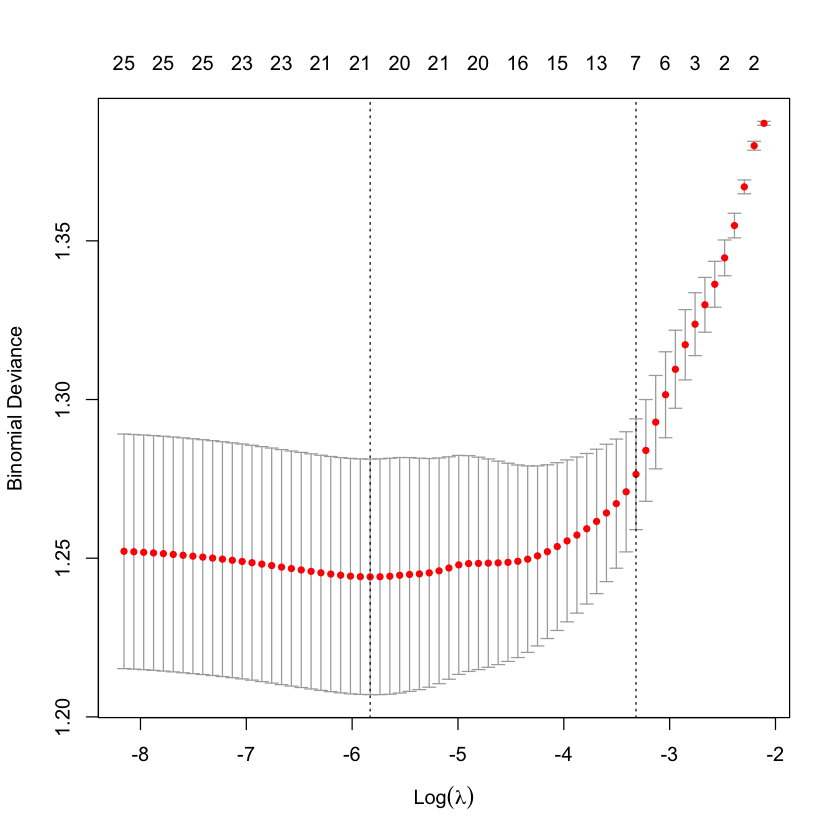

In [86]:
##Régression logistique avec régularisation ridge
#Sélection du lambda par validation croisée à 10 plis
cv.glmn2 <- cv.glmnet(x = TRAIN.df[,var.model] %>% as.matrix,
                    y = TRAIN.df[,"STATUT"], alpha = 1, nfolds = 10,
                    foldid = PARTITION, family = "binomial")

glmn2 <- glmnet(x = TRAIN.df[,var.model] %>%
                as.matrix, y = TRAIN.df[,"STATUT"], alpha = 1, family = "binomial",
                lambda = cv.glmn2$lambda.min)

#Visualisation des résultats de la validation croisée avec régularisation lasso (valeur de lambda optimale indiquée par les lignes verticales pointillées)
plot(cv.glmn2)

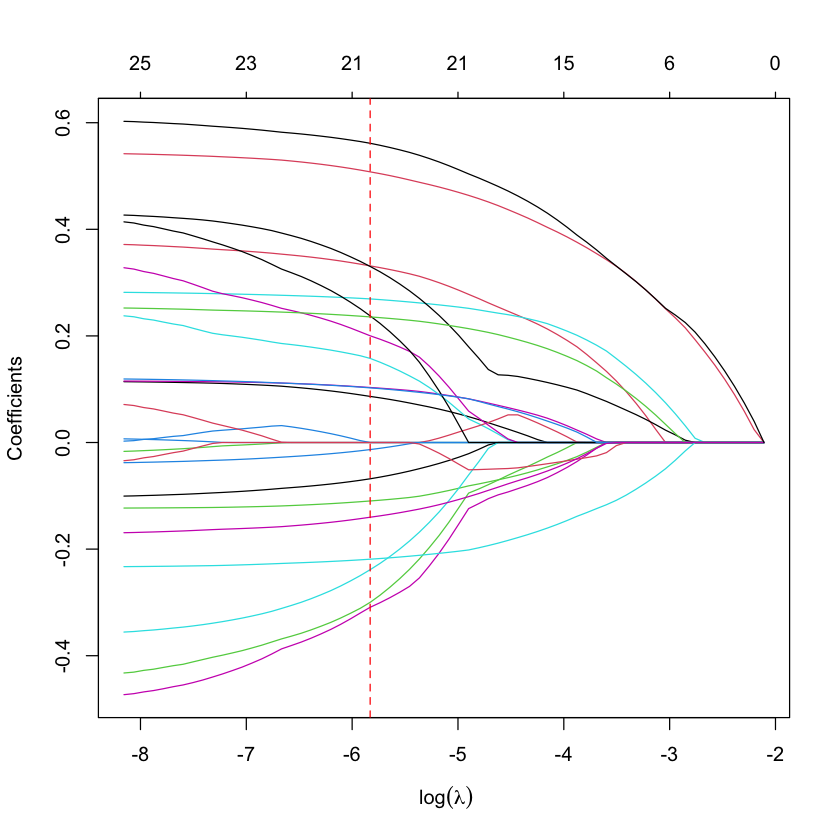

In [87]:
##Régression logistique avec régularisation ridge 
glmn2.0 <- glmnet(x = TRAIN.df[,var.model] %>% as.matrix,
                  y = TRAIN.df[,"STATUT"], alpha = 1, family = "binomial")

#Visualisation: évolution des coefficients selon valeur de lambda avec régularisation lasso + ligne rouge indiquant le lambda optimal
plot(glmn2.0, xvar = "lambda", label = FALSE, xlab = ~log(lambda))
abline(v = log(cv.glmn2$lambda.min), lty = 2, col = "red")

In [88]:
#Prédiction à l'aide de la régression logistique avec régularisation ridge
glmn2p <- predict(cv.glmn2, newx = TRAIN.df[,var.model] %>%
                  as.matrix, s = "lambda.min")

In [89]:
#Table de classification montrant la performance prédictive du modèle
cv3 <- table(1*(glmn2p>0), TRAIN.df$STATUT)
cv3
prop.table(cv3)*100
sprintf("%.1f%% de bonne classification", sum(diag(prop.table(cv3)))*100)

   
    -1.0021446507074 0.996434424777448
  0              242               104
  1              107               247

   
    -1.0021446507074 0.996434424777448
  0        0.3457143         0.1485714
  1        0.1528571         0.3528571

[1] "69.9% de bonne classification"

In [90]:
#Ajustement de la matrice
layout(matrix(1:10,3,3, byrow = TRUE))

Warning message in matrix(1:10, 3, 3, byrow = TRUE):
“la longueur des données [10] n'est pas un diviseur ni un multiple du nombre de lignes [3]”


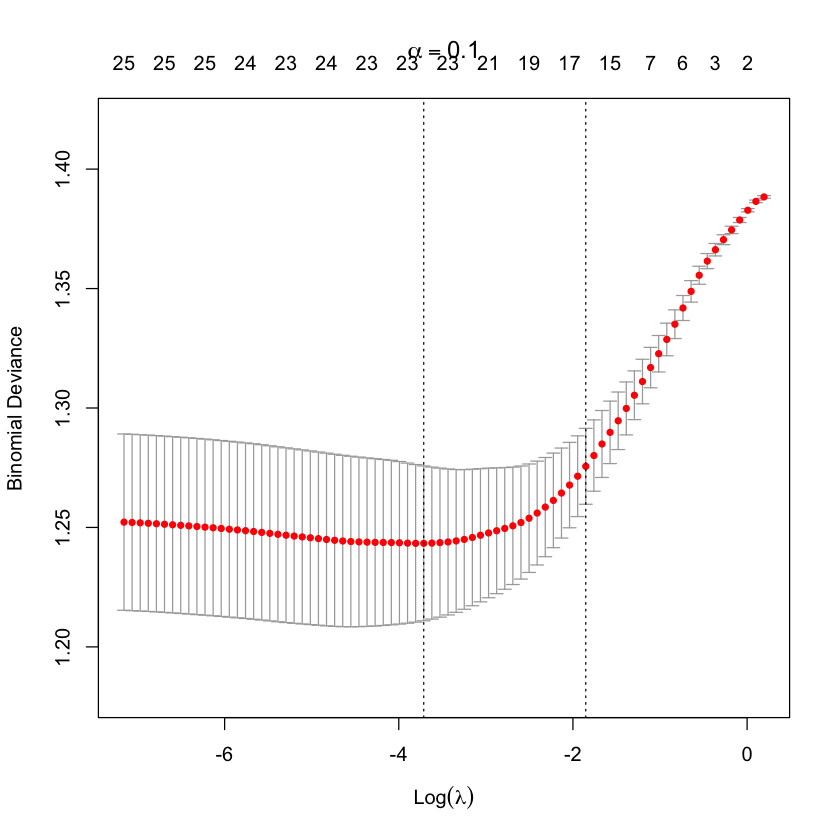

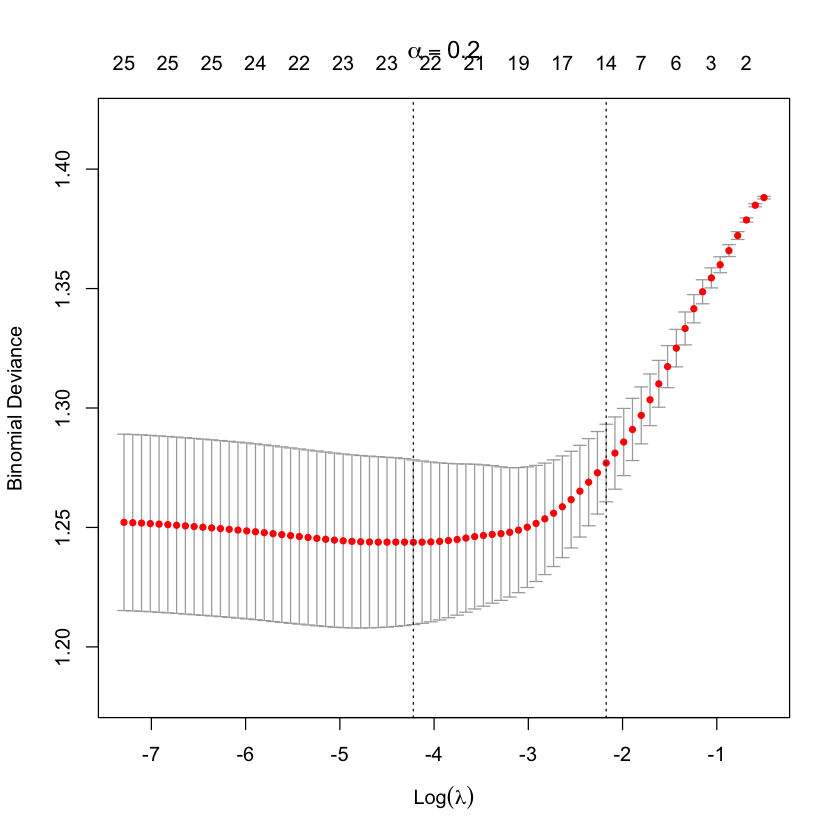

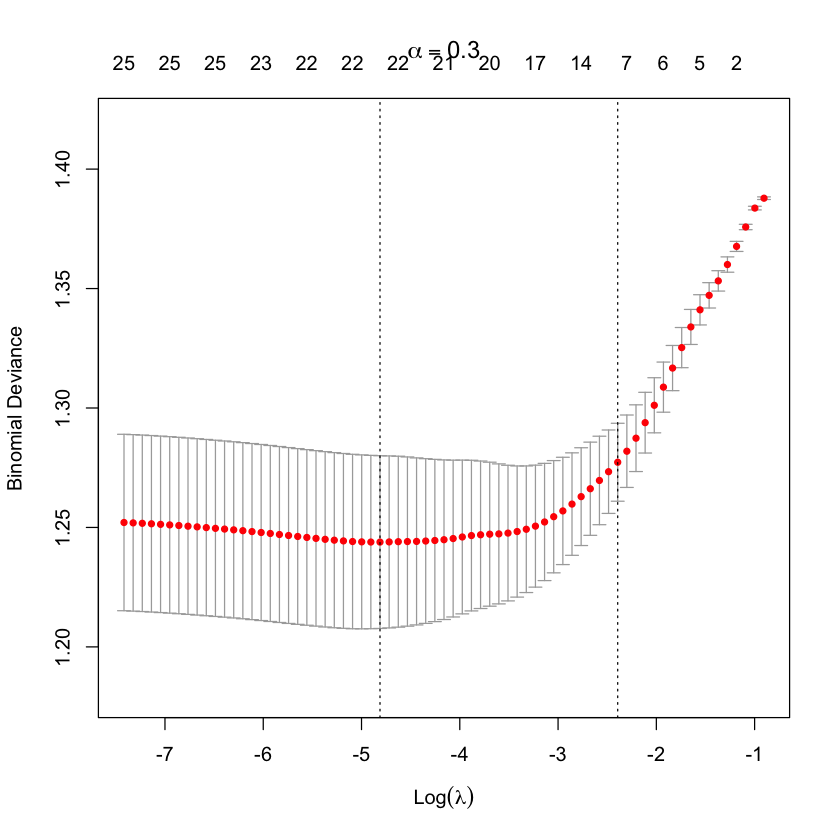

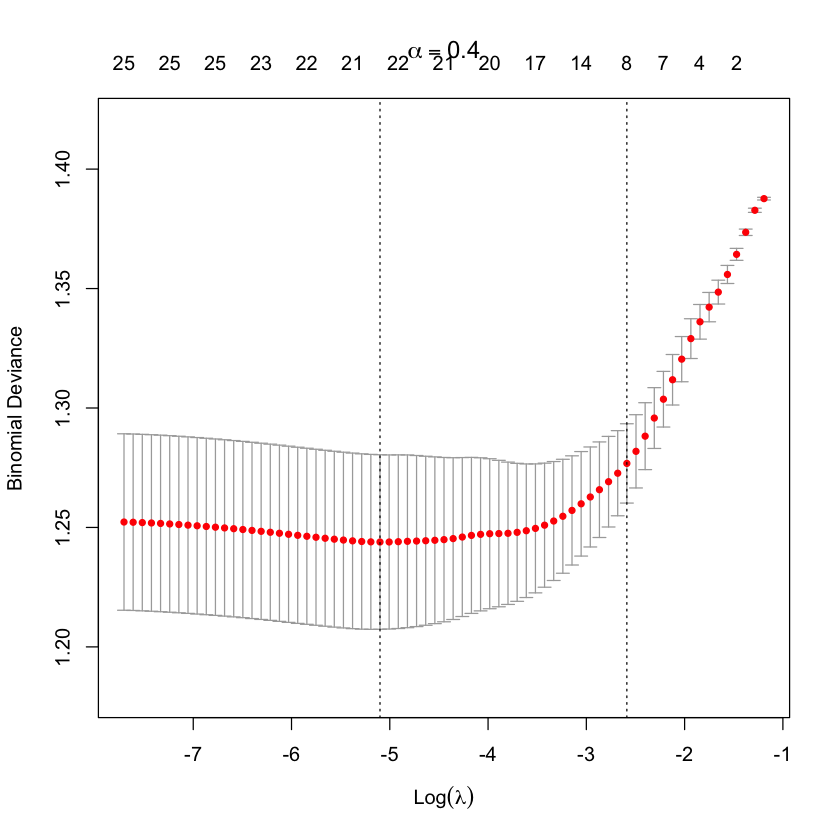

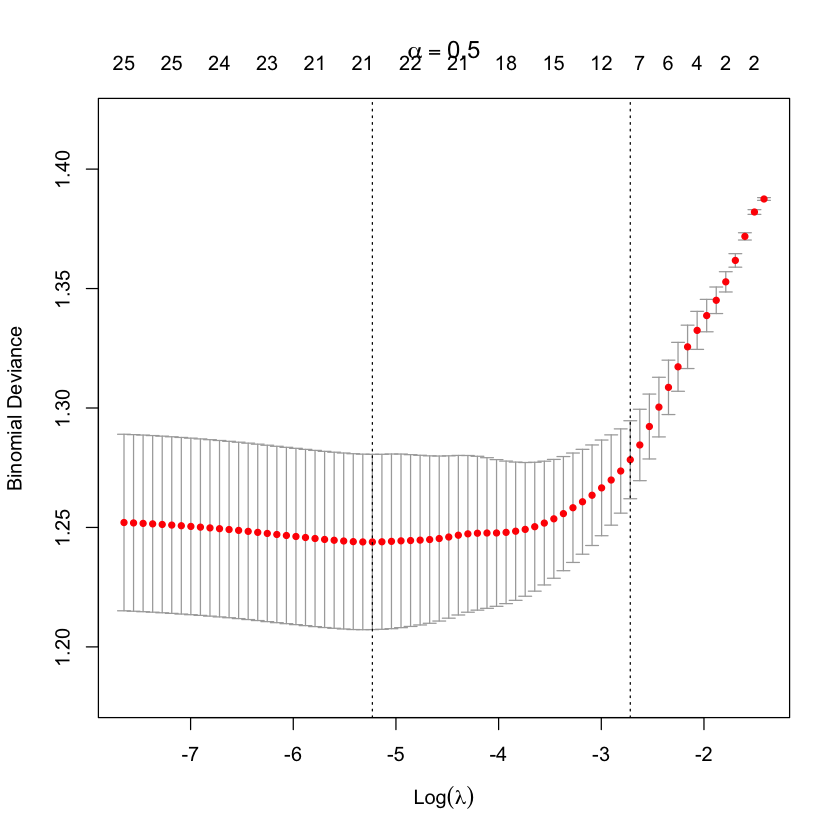

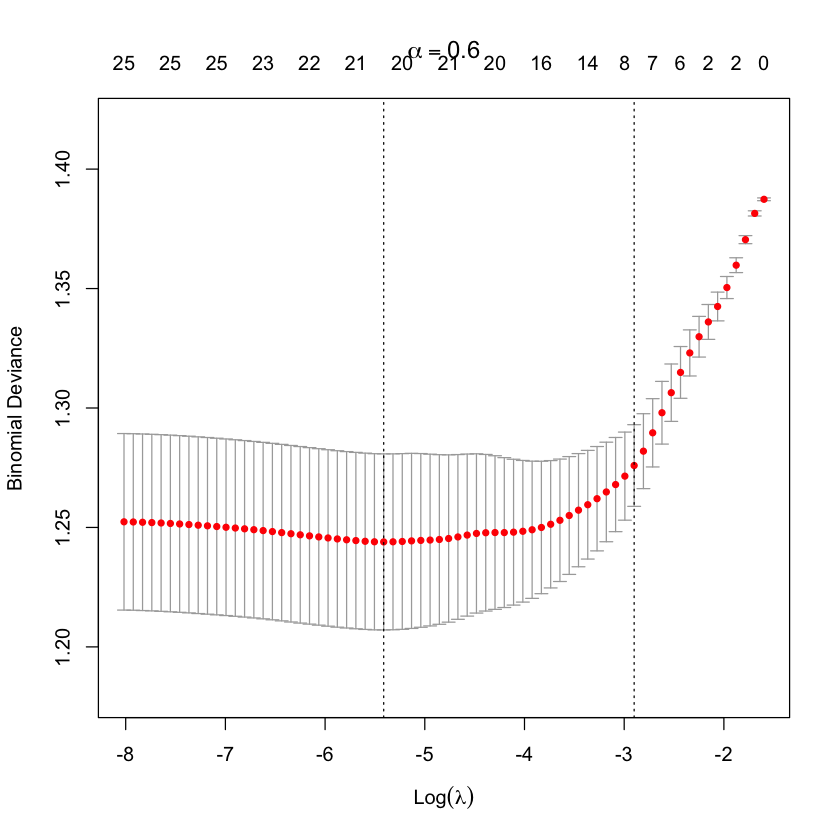

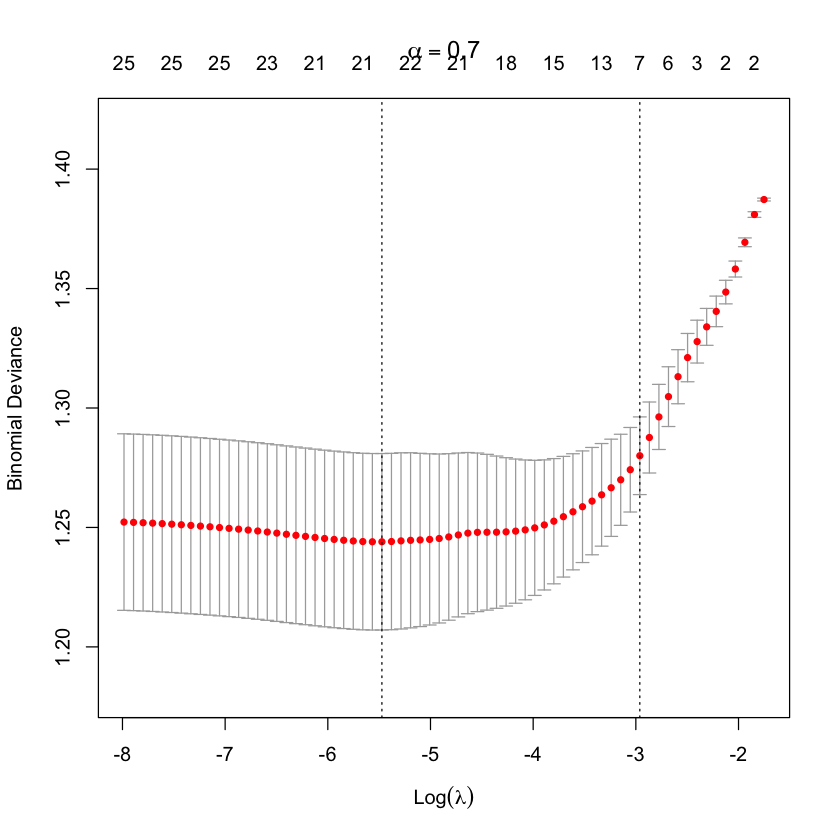

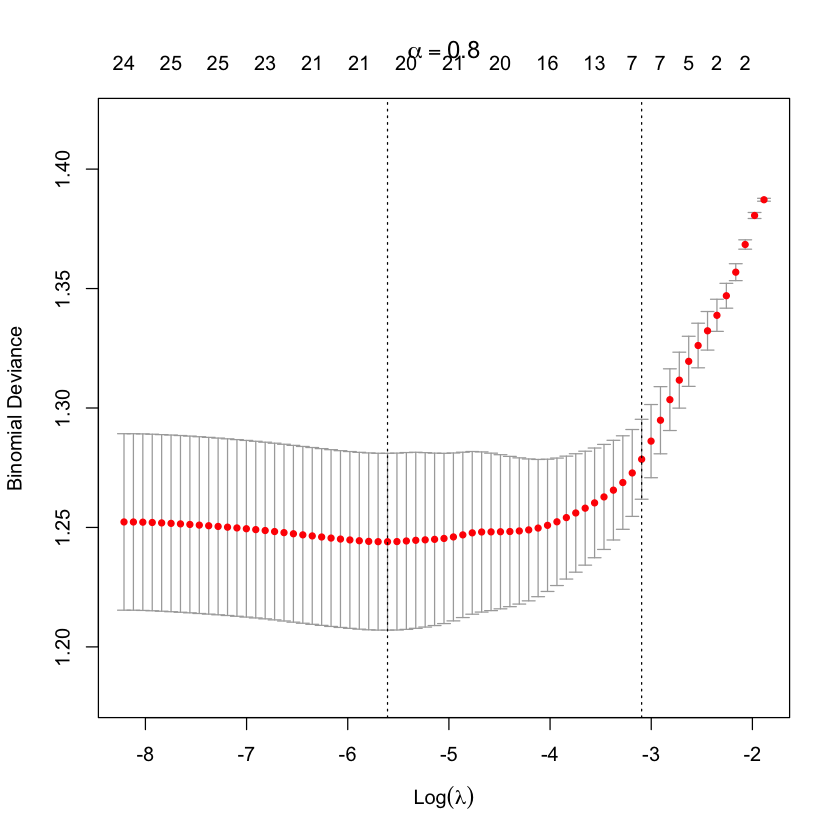

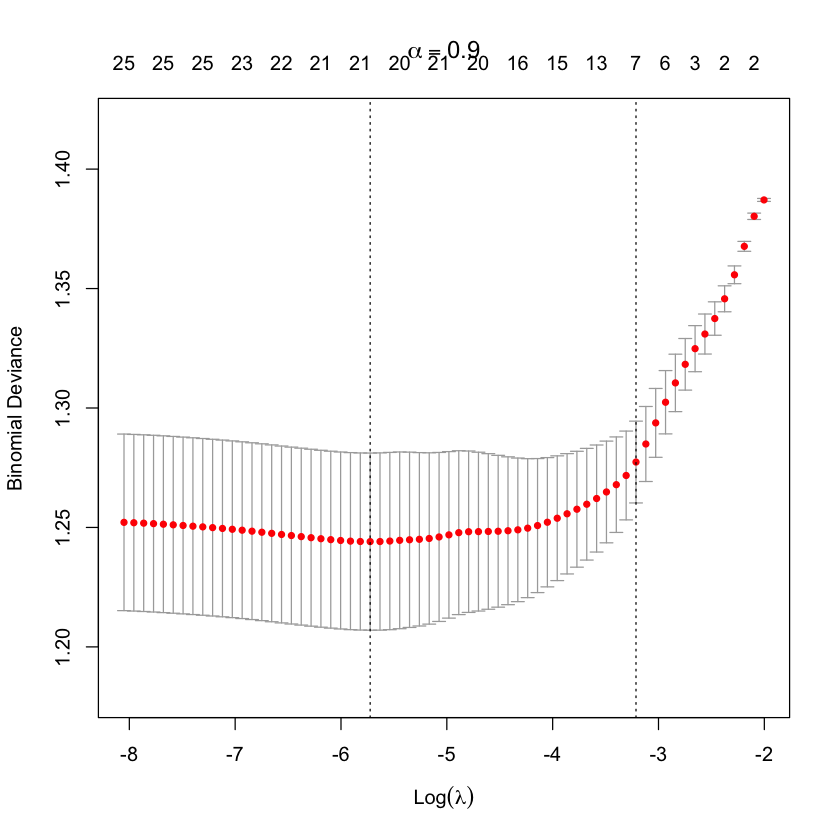

In [91]:
#Validation croisée à 10-plis pour obtention de la valeur optimale de lambda selon la valeur d'alpha (au dixième près)
cv.glmn3 <- list()

for(al in seq(0.1,0.9,0.1)){
    cv.glmn3[[sprintf("%.1f",al)]] <-
    cv.glmnet(x = TRAIN.df[,var.model] %>% as.matrix,
    y = TRAIN.df[,"STATUT"], nfolds = 10, foldid = PARTITION,
    alpha = al, family = "binomial")
plot(cv.glmn3[[sprintf("%.1f",al)]],
main = latex2exp::TeX(sprintf("$\\alpha = %.1f$",al)), ylim = c(1.18, 1.42))
}

In [92]:
#Résumé: lambda optimal pour chaque valeur d'alpha
layout (1)
lapply(cv.glmn3, function(x) c(x$cvm[x$lambda == x$lambda.min],
+ x$cvsd[x$lambda == x$lambda.min]))

$`0.1`
[1] 1.24334596 0.03240747

$`0.2`
[1] 1.24380465 0.03446807

$`0.3`
[1] 1.24387059 0.03614771

$`0.4`
[1] 1.24390553 0.03652575

$`0.5`
[1] 1.24393115 0.03668735

$`0.6`
[1] 1.24394632 0.03684874

$`0.7`
[1] 1.24399564 0.03693823

$`0.8`
[1] 1.24402662 0.03701833

$`0.9`
[1] 1.24406738 0.03707612

In [93]:
#Régression logistique avec régularisation elastic-net (lambda et alpha choisis par validation croisée précédemment) 
glmn3 <- glmnet(x = TRAIN.df[,var.model] %>% as.matrix,
          y = TRAIN.df[,"STATUT"], alpha = 0.1, family = "binomial",
          lambda = cv.glmn3[[9]]$lambda.min)

In [94]:
#Prédiction à l'aide de la régression logistique avec régularisation elastic-net
glmn3p <- predict(cv.glmn3[[9]], newx = TRAIN.df[,var.model] %>% as.matrix)

In [95]:
#Table de classification montrant la performance prédictive du modèle
cv4 <- table(1*(glmn3p>0), TRAIN.df$STATUT)
cv4
prop.table(cv4)*100
sprintf("%.1f%% de bonne classification", sum(diag(prop.table(cv4)))*100)

   
    -1.0021446507074 0.996434424777448
  0              240               117
  1              109               234

   
    -1.0021446507074 0.996434424777448
  0        0.3428571         0.1671429
  1        0.1557143         0.3342857

[1] "67.7% de bonne classification"

In [96]:
#Prédiction avec les données test à partir de chaque modèle créé ci-haut
glm1tp <- predict(glm1, newx = TEST.df[,var.model] %>% as.matrix, s = "lambda.min")
glmn1tp <- predict(cv.glmn1, newx = TEST.df[,var.model] %>% as.matrix, s = "lambda.min")
glmn2tp <- predict(cv.glmn2, newx = TEST.df[,var.model] %>% as.matrix, s = "lambda.min")
glmn3tp <- predict(cv.glmn3[[9]], newx = TEST.df[,var.model] %>%as.matrix, s = "lambda.min")

In [99]:
#Table de classification résumant la performance du modèle additif sur les données test
cvt1 <- table(1*(glm1tp>0), TEST.df$STATUT)
cvt1
prop.table(cvt1)*100
sprintf("%.1f%% de bonne classification", sum(diag(prop.table(cvt1)))*100)

   
    -0.991698433831807 1.00500982220539
  0                100               49
  1                 51              100

   
    -0.991698433831807 1.00500982220539
  0          0.3333333        0.1633333
  1          0.1700000        0.3333333

[1] "66.7% de bonne classification"

In [102]:
#Table de classification résumant la performance du modèle avec régularisation ridge sur les données test
cvt2 <- table(1*(glm1tp>0), TEST.df$STATUT)
cvt2
prop.table(cvt2)*100
sprintf("%.1f%% de bonne classification", sum(diag(prop.table(cvt2)))*100)

   
    -0.991698433831807 1.00500982220539
  0                100               49
  1                 51              100

   
    -0.991698433831807 1.00500982220539
  0          0.3333333        0.1633333
  1          0.1700000        0.3333333

[1] "66.7% de bonne classification"

In [104]:
#Table de classification résumant la performance du modèle avec régularisation lasso sur les données test
cvt3 <- table(1*(glmn2tp>0), TEST.df$STATUT)
cvt3
prop.table(cvt3)*100
sprintf("%.1f%% de bonne classification", sum(diag(prop.table(cvt3)))*100)

   
    -0.991698433831807 1.00500982220539
  0                101               49
  1                 50              100

   
    -0.991698433831807 1.00500982220539
  0          0.3366667        0.1633333
  1          0.1666667        0.3333333

[1] "67.0% de bonne classification"

In [105]:
#Table de classification résumant la performance du modèle avec régularisation elastic-net sur les données test
cvt4 <- table(1*(glmn3tp>0), TEST.df$STATUT)
cvt4
prop.table(cvt4)*100
sprintf("%.1f%% de bonne classification", sum(diag(prop.table(cvt4)))*100)

   
    -0.991698433831807 1.00500982220539
  0                101               49
  1                 50              100

   
    -0.991698433831807 1.00500982220539
  0          0.3366667        0.1633333
  1          0.1666667        0.3333333

[1] "67.0% de bonne classification"

In [106]:
#Bootstrap
set.seed(1234)
good.class <- function(model, i ){
            if("glm" %in% class(model)){
            glm1tp <- predict(glm1, newdata = TEST.df[i,])
            cvt1 <- table(1*(glm1tp>0), TEST.df$STATUT[i])
            sum(diag(prop.table(cvt1)))*100
}
  else {glmn3tp <- predict(model,
                           newx = TEST.df[i,var.model] %>% as.matrix, s = "lambda.min")
  (cvt4 <- table(1*(glmn3tp>0), TEST.df$STATUT)) %>%
sum(diag(prop.table(cvt4)))*100
  }
}

sd(replicate(1000,good.class(glm1, sample(1:300, 300, TRUE))))

[1] 2.860233

In [107]:
#Tableau de comparaison des coefficients de chaque modèle
length(drop(coef(cv.glmn3[[6]],
       s = "lambda.min",allCoef = TRUE)))

coef(cv.glmn3[[6]], s = "lambda.min",allCoef = TRUE)

cf <- data.frame(VAR = c("Int.", var.model),
                 OLS = drop(coef(glm1, s = "lambda.min",allCoef = TRUE)),
                 RIDGE = drop(coef(cv.glmn1,s = "lambda.min",allCoef = TRUE)),
                 LASSO = drop(coef(cv.glmn2,s = "lambda.min",allCoef = TRUE)),
                 `ELASTIC NET` = drop(coef(cv.glmn3[[6]],
                                           s = "lambda.min",allCoef = TRUE)))
kable(cf, digits = 2,row.names = FALSE)


[1] 26

26 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)    0.01013546
MALE           0.08685561
AGE            0.32715857
PAR_IMM        .         
MINORITY       .         
SCOLMAX        0.26739839
TRAVAILM       0.10375917
TRAVAILP      -0.06856472
PAR_SEP        0.50403987
ADAPT         -0.10908915
SRDQ          -0.01417881
EVDISTSEV      0.15589798
EVDISTMOD     -0.30191322
SEVER03DICO    0.32154633
SEVER36DICO    .         
SEVER69DICO   -0.29121185
SEVER912DICO   .         
MODER203DICO  -0.22970279
MODER236DICO   0.19622058
MODER269DICO   0.22864685
MODER2912DICO  .         
LOW203DICO     0.23449993
LOW236DICO     0.10313554
LOW269DICO    -0.21882702
LOW2912DICO   -0.13987804
CHRONSEVACT    0.55478994



|VAR           |   OLS| RIDGE| LASSO| ELASTIC.NET|
|:-------------|-----:|-----:|-----:|-----------:|
|Int.          |  0.01|  0.01|  0.01|        0.01|
|MALE          |  0.12|  0.09|  0.09|        0.09|
|AGE           |  0.38|  0.26|  0.33|        0.33|
|PAR_IMM       | -0.02|  0.01|  0.00|        0.00|
|MINORITY      |  0.01|  0.00|  0.00|        0.00|
|SCOLMAX       |  0.28|  0.24|  0.27|        0.27|
|TRAVAILM      |  0.12|  0.10|  0.10|        0.10|
|TRAVAILP      | -0.11| -0.07| -0.07|       -0.07|
|PAR_SEP       |  0.55|  0.45|  0.51|        0.50|
|ADAPT         | -0.12| -0.10| -0.11|       -0.11|
|SRDQ          | -0.04| -0.02| -0.01|       -0.01|
|EVDISTSEV     |  0.26|  0.10|  0.16|        0.16|
|EVDISTMOD     | -0.50| -0.19| -0.31|       -0.30|
|SEVER03DICO   |  0.43|  0.24|  0.33|        0.32|
|SEVER36DICO   | -0.06|  0.05|  0.00|        0.00|
|SEVER69DICO   | -0.46| -0.19| -0.30|       -0.29|
|SEVER912DICO  | -0.01|  0.05|  0.00|        0.00|
|MODER203DICO  | -0.37| -0.14